In [1]:
import pandas as pd
import numpy as np
from minepy import MINE
import minepy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_regression

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv("WHO.csv")

In [4]:
data.columns

Index(['Country', 'CountryID', 'Continent', 'Adolescent fertility rate (%)',
       'Adult literacy rate (%)',
       'Gross national income per capita (PPP international $)',
       'Net primary school enrolment ratio female (%)',
       'Net primary school enrolment ratio male (%)',
       'Population (in thousands) total', 'Population annual growth rate (%)',
       ...
       'Total_CO2_emissions', 'Total_income', 'Total_reserves',
       'Trade_balance_goods_and_services', 'Under_five_mortality_from_CME',
       'Under_five_mortality_from_IHME', 'Under_five_mortality_rate',
       'Urban_population', 'Urban_population_growth',
       'Urban_population_pct_of_total'],
      dtype='object', length=358)

Exclude the first two columns, that are just the name of the country and the ID

In [5]:
data = data.iloc[:,2:]  

In [6]:
len(data.columns)

356

Number of pairs:

In [7]:
len(data.columns)*(len(data.columns)-1)/2

63190.0

I want to perform analysis on every possible variable with MINE, the neural estimation and Kraskov one for mutual information and standard Pearson correlation coefficient. 

Start with a subset of the columns

In [9]:
reduced_data = data.iloc[:,:]

## Define the functions to perform the pairwise stuff

In [10]:
from neural_estimation import pairwise_neural_estimation_MI

In [11]:
def pairwise_corr(df):
    # each column of df represent a variable, each row an observation.
    
    num_vars = len(df.columns)
    
    return df.corr().as_matrix()[np.triu_indices(num_vars, k=1)]

In [12]:
def pairwise_kraskov_MI(df, n_neighbors=3):
    # each column of df represent a variable, each row an observation.
    # the returned vector contains -2 when all the elements of the considered pair are NaN, and it returns -1 when 
    # there are too few not NaN elements for the kNN algorithm to work.
    
    num_vars = len(df.columns)
    
    corr_matrix = np.zeros((num_vars, num_vars))
    
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            pair = df.iloc[:,[i, j]].dropna()
            if len(pair) == 0:
                corr_matrix[i,j] = -2
            elif len(pair) <= n_neighbors: 
                corr_matrix[i,j] = -1
                #print(i,j, corr_matrix[i, j])
            else: 
                corr_matrix[i,j] = mutual_info_regression(pair.iloc[:,0].values.reshape(-1, 1), 
                                                      pair.iloc[:,1].values.reshape(-1, 1), n_neighbors=n_neighbors)
    
    return corr_matrix[np.triu_indices(num_vars, k=1)]

It may happen that all the rows of the pair of varibles are NaN, in that case it does not make sense to estimate the MI. Anyway, the MIC still returns an estimate. 
Moreover, If you have less than `n_neighbors+1` valid points in the pair, the Kraskov algorithm does not work. We will exlude both these cases from the analisys of both the Pearson correlation and the MIC. 

In [12]:
%%time
mic, tic = minepy.pstats(reduced_data.T)

CPU times: user 9.3 s, sys: 6.02 ms, total: 9.31 s
Wall time: 9.31 s


In [178]:
# BE CAREFUL WITH THIS!
#np.save("MIC_WHO", mic)

In [117]:
mic = np.load("MIC_WHO.npy")

In [118]:
%%time 
pearson_corr = pairwise_corr(reduced_data)

CPU times: user 58.2 ms, sys: 209 µs, total: 58.4 ms
Wall time: 57.3 ms


In [14]:
%%time
kraskov_MI = pairwise_kraskov_MI(reduced_data)

CPU times: user 1.96 s, sys: 4.84 ms, total: 1.97 s
Wall time: 1.98 s


In [143]:
# BE CAREFUL!
# np.save("kraskov_MI_WHO", kraskov_MI)

In [119]:
kraskov_MI = np.load("kraskov_MI_WHO.npy")

I will now remove the invalid indeces; apparently, almost all elements of column 319 are NaN

In [120]:
print(sum(kraskov_MI<0), sum(kraskov_MI==-1), sum(kraskov_MI==-2))

641 210 431


In [121]:
valid_indices = kraskov_MI >= 0
print(sum(valid_indices==True))

62549


In [122]:
mic = mic[valid_indices]
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]

There are still some values for which the pearson correlation is NaN; eliminate these cases as well (no idea why this happens)

In [123]:
print(sum(np.isnan(pearson_corr)), sum(np.isnan(mic)), sum(np.isnan(kraskov_MI)))

10 0 0


In [124]:
valid_indices = np.isfinite(pearson_corr)
mic = mic[valid_indices]
pearson_corr = pearson_corr[valid_indices]
kraskov_MI = kraskov_MI[valid_indices]

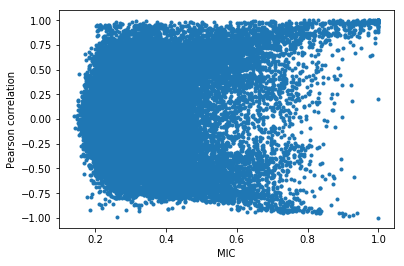

In [125]:
plt.plot(mic, pearson_corr, ".")
plt.xlabel("MIC")
plt.ylabel("Pearson correlation")
plt.show()

Text(0,0.5,'Pearson correlation')

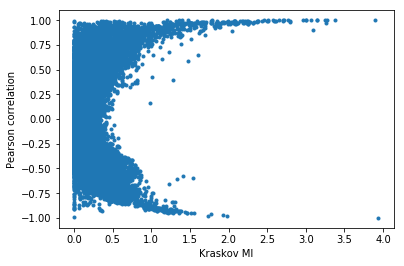

In [126]:
plt.plot(kraskov_MI, pearson_corr, ".")
plt.xlabel("Kraskov MI")
plt.ylabel("Pearson correlation")

## Try now the neural estimation.
It is pretty slow, I run it just on columns from 318 on.

In [20]:
%%time
neural_MI = pairwise_neural_estimation_MI(reduced_data, n_epoch=400)

100%|██████████| 400/400 [00:00<00:00, 586.96it/s]


100%|██████████| 400/400 [00:00<00:00, 607.72it/s]


100%|██████████| 400/400 [00:00<00:00, 573.84it/s]


100%|██████████| 400/400 [00:00<00:00, 442.34it/s]


100%|██████████| 400/400 [00:00<00:00, 627.15it/s]

CPU times: user 36min 56s, sys: 14.2 s, total: 37min 10s
Wall time: 6min 34s


In [31]:
np.save("neural_MI_WHO_from_col318_toend", neural_MI)

In [ ]:
neural_MI = np.load("neural_MI_WHO_from_col318_toend")

In [32]:
neural_MI = neural_MI[valid_indices]

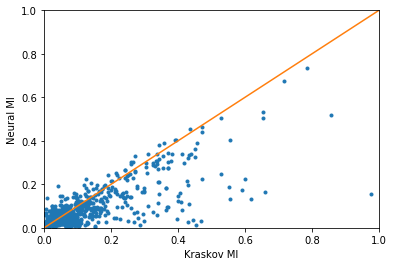

In [33]:
plt.plot(kraskov_MI, neural_MI[:, 0], ".")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Kraskov MI")
plt.ylabel("Neural MI")
plt.plot(np.linspace(0,1), np.linspace(0,1))

Neural estimation tends to be smaller than kraskov one

Text(0.5,0,'Neural MI')

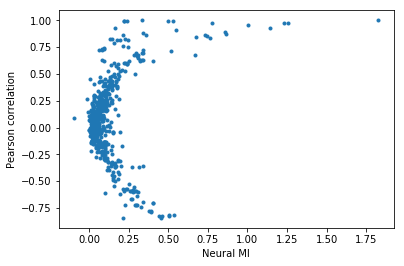

In [34]:
plt.plot(neural_MI[:, 0], pearson_corr, ".")
plt.ylabel("Pearson correlation")
plt.xlabel("Neural MI")

# Scatterplot according to density

In [164]:
from scipy.stats import gaussian_kde

#cmaps: plasma, rainbow, jet

def compute_density(x, y):
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    return z
    
def density_scatterplot(x, y, z, s=10):
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots(figsize=(6, 9))
    ax.scatter(x, y, c=z, s=s, edgecolor='', cmap=plt.get_cmap("plasma"))
    
    return fig, ax

In [138]:
%%time 
mic_pearson_density = compute_density(mic, pearson_corr)

CPU times: user 1min 35s, sys: 1.92 ms, total: 1min 35s
Wall time: 1min 36s


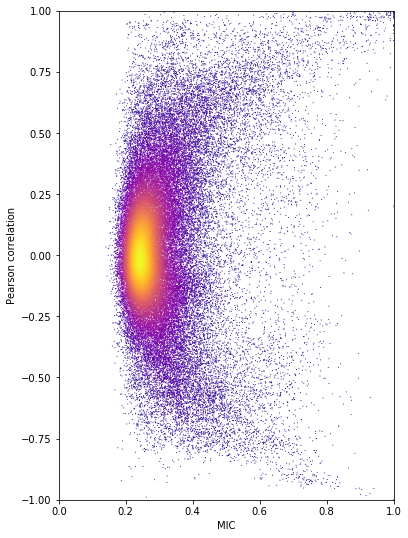

In [165]:
fig, ax = density_scatterplot(mic, pearson_corr, mic_pearson_density, s=1)
ax.set_xlabel("MIC")
ax.set_ylabel("Pearson correlation")
ax.set_xlim([0,1])
ax.set_ylim([-1,1])
plt.show()

In [140]:
%%time 
kraskov_pearson_density = compute_density(kraskov_MI, pearson_corr)

CPU times: user 1min 34s, sys: 69.9 ms, total: 1min 34s
Wall time: 1min 35s


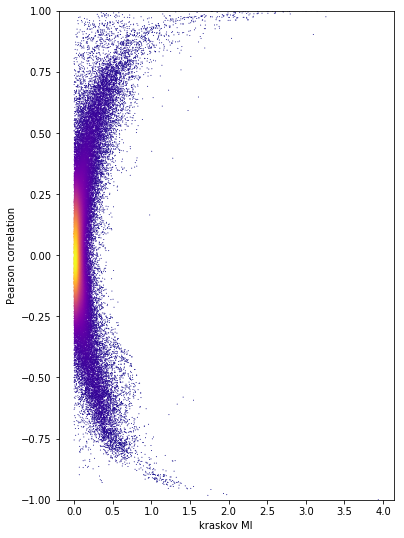

In [166]:
fig, ax = density_scatterplot(kraskov_MI[kraskov_MI!=0], pearson_corr[kraskov_MI!=0], kraskov_pearson_density[kraskov_MI!=0], s=1)
ax.set_xlabel("kraskov MI")
ax.set_ylabel("Pearson correlation")
ax.set_ylim([-1,1])
plt.show()

A large number of points are estimated with 0 kraskov_MI. Which is the reason for this??

In [148]:
sum(kraskov_MI==0)/len(kraskov_MI)

0.21653688098626456